In [4]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from src.data.datasets import ModelParamsDataset

from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.model.models import DBModelSmall, DBModelBig, Autoencoder

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from src.visualization.visualize import plot_interpolation, plot_decision_boundary

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Regular

In [6]:
# Hyperparameters
epochs = 100
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
in_out_dim = 33
latent_dim = 2
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = Autoencoder(in_out_dim, latent_dim, dropout)
model = DBModelSmall()
model.requires_grad_(False)

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv")
train_indices, test_indices, _, _ = train_test_split(range(len(dataset)), dataset.angles, stratify=dataset.angles, test_size=0.2, random_state=random_seed)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Locations
path = "../../models/autoencoders/autoencoder_mseloss"
model_path = "{}/autoencoder_mseloss.pth".format(path)

## Train

In [ ]:
autoencoder.train()
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in train_dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        reconstructed = autoencoder(parameters_batch)

        optimizer.zero_grad()
        loss = loss_fn(reconstructed, parameters_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    if(epoch % 5 == 0):
        torch.save(autoencoder.state_dict(), f"{path}/checkpoint_{epoch}.pth")

torch.save(autoencoder.state_dict(), model_path)

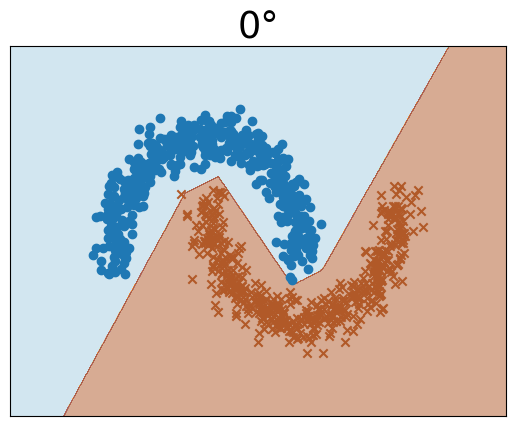

In [9]:
autoencoder = Autoencoder(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()
model = DBModelSmall(batch_first=False)
plt.rcParams.update({'font.size': 22})

index = 5
parameters = dataset[index][0].unsqueeze(0)
angle = dataset[index][1].item()
reconstructed = autoencoder(parameters).squeeze()
X, y = get_moons_dataset()
X_rotated = rotate(X, angle)
model.set_weights(parameters.squeeze())
plot_decision_boundary(model, X_rotated, y, title=f"{angle}°", save_path=f"../../reports/autoencoder-mseloss-sample-{angle}.pdf", axis=False, legend=False)
# plot_decision_boundary(reconstructed.squeeze(), X, y, title=f"Reconstructed decision boundary from {latent_dim} variables")

## Latent space

(80000, 2)
(80000, 2)


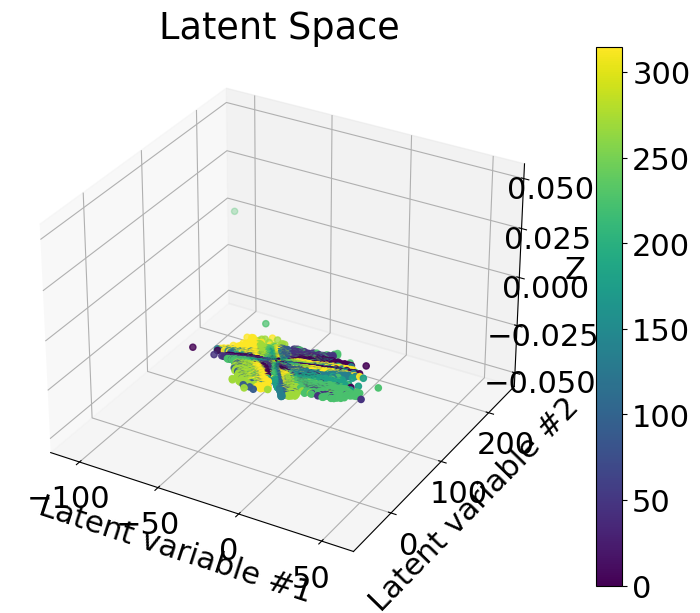

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

autoencoder = Autoencoder(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../../data/zoo_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

weights = torch.tensor(weights).float()
latent = autoencoder.encoder(weights).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
# X_pca = pca.fit_transform(latent)
X_pca = latent
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.title("Latent Space")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.show()

## Reconstructed weigths distribution

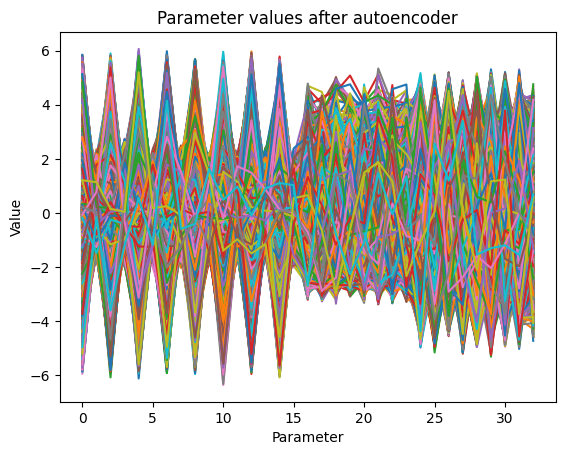

In [7]:
from matplotlib import pyplot as plt

autoencoder = Autoencoder(in_out_dim, latent_dim, dropout)

autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()


reconstruction = []
for i in range(10000):
    parameters = dataset[i][0].unsqueeze(0)
    r = autoencoder(parameters)
    r = r.squeeze().detach().numpy()
    reconstruction.append(r)


for r in reconstruction:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.title("Parameter values after autoencoder")
plt.show()

## Accuracy distribution

  0%|          | 0/80000 [00:00<?, ?it/s]

Mean trained accuracy: 99.87490625000002
Mean reconstructed accuracy: 67.63027374999999


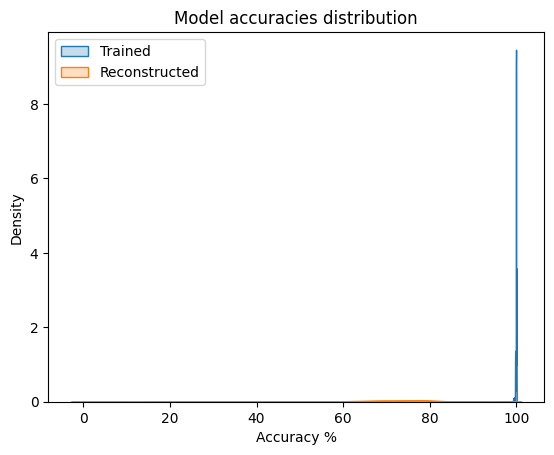

In [16]:
autoencoder = Autoencoder(in_out_dim, latent_dim, dropout)

autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

model = DBModelSmall(batch_first=False)

dataset = ModelParamsDataset("../../data/zoo_small.csv")

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)
    
    model.set_weights(parameter)
    accuracy = get_accuracy(model, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()

    model.set_weights(reconstructed)
    accuracy = get_accuracy(model, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()


## Interpolation

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 83.10861142857144


Text(0.5, 0, 'Accuracy %')

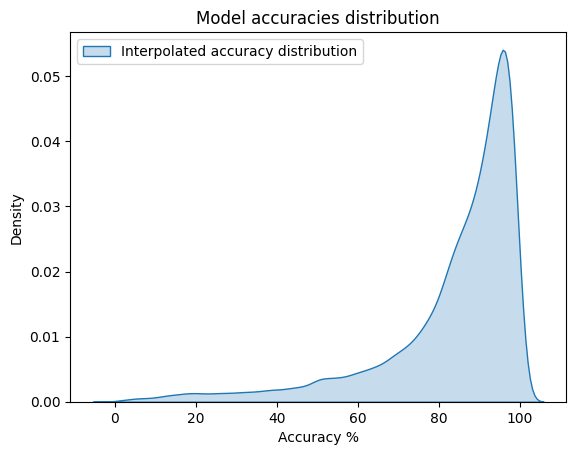

In [16]:
autoencoder = Autoencoder(16)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

model = DBModelSmall(batch_first=False)

raw = pd.read_csv("../data/zoo_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()

        model.set_weights(w)
        accuracy = get_accuracy(model, X_rotated, y)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
# plt.show()

In [18]:
autoencoder = Autoencoder(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/zoo_small.csv")

X, y = get_moons_dataset()

alpha = 0.8
index_1 = 0
index_2 = 60000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

interact(plot_interpolation, model=fixed(autoencoder), datapoint_1=fixed(datapoint_1), datapoint_2=fixed(datapoint_2), X=fixed(X), y=fixed(y), alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

<function src.visualization.visualize.plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha)>

In [101]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/zoo_small.csv")
save_path = "../reports/figures/new_loss"
X, y = get_moons_dataset()

index_1 = 0
index_2 = 10000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]   

parameters_1, angle_1 = datapoint_1
parameters_2, angle_2 = datapoint_2

parameters_1 = parameters_1.unsqueeze(0)
parameters_2 = parameters_2.unsqueeze(0)

latent_1 = autoencoder.encoder(parameters_1)
latent_2 = autoencoder.encoder(parameters_2)

for i in range(0, 105, 10):

    alpha = i/100

    latent = (1-alpha)*latent_1 + alpha*latent_2

    w = autoencoder.decoder(latent).squeeze()

    angle = (1-alpha)*angle_1 + alpha*angle_2
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float()

    plot_decision_boundary(w, X_rotated, y)
    plt.savefig(save_path + "/alpha_{}.png".format(alpha))
    plt.close()